In [1]:
import numpy as np
import matplotlib.pyplot as pl

In [2]:
def f(x): 
    y = 1/(1+x**2)
    return y

# Task A

In [3]:
# Task A1
# Simpson
def Simpson(h,yn):
    # number of nodal points
    N = len(yn)
    # initialise sum
    S = 0
    # loop every two points, and use the three points for Simpson rule
    # current point yn[i] and successive two points yn[i+1], yn[i+2]
    for i in range(0,N-2,2):
        S += h/3 * ( yn[i] + 4*yn[i+1] + yn[i+2] )
    return S

In [4]:
# Evaluate the integral of sin(x)
dx = 0.001
xn = np.arange(0,1.0+dx,dx)
yn = f(xn)
# yn = np.exp(-xn**2)
# estabish the step
h = xn[1] - xn[0]
# compute integral with Simpson rule
S = Simpson(h,yn)
print(S)    

0.785398163397448


In [5]:
# adaptive Simpson

# set a desired tolerance
tol = 1.0e-6
# set the domain of integration
a = 0.0
b = 1.0

# start with minimal number of sub intervals: one
# M is number of subintervals
M = 1
# determine the the nodal points for the present interval
xn = np.linspace(a,b,M+1)
yn = f(xn)
# determine the size of the interval
h = xn[1] - xn[0]
# compute integral with Simpson rule
S = Simpson(h,yn)
# set a fake error larger than the tolerance, to enter the while loop
err = tol * 10
# keep reducing the interval size if tolerance not reached
while err >= tol:
    # half the size of subintervals
    M = 2 * M
    # determine the the nodal points for the present intervals
    xn = np.linspace(a,b,M+1)   
    yn = f(xn)
    # determine the size of the intervals
    h = xn[1] - xn[0]
    # compute integral with Simpson rule
    Shalf = Simpson(h,yn)
    # compute the error, between present half size and previous size
    err = 1/15*np.abs(Shalf - S)
    # set current size as previous
    S = Shalf

# analytical solution:
Sa = np.pi/4

print('Integral: ',S)
print('Analytical: ',Sa)
print('Number of nodes used: ',M+1)
print('Error achieved: ',err)

Integral:  0.7853981256146766
Analytical:  0.7853981633974483
Number of nodes used:  9
Error achieved:  3.9791679543229224e-07


# Task B

In [6]:
# Task B
# Binomial coefficient
def Fact(n):
    f = 1
    for i in range(1,n+1):
        f *= i
    return f

def BinCoeff(n,k):
    # as defined in the formula
    B = Fact(n)/(Fact(k)*Fact(n-k))
    return B
    

In [7]:
# k-th derivative with forward scheme
def Derivative(yn,h,k):
    # yn: the nodal points
    # h: the size of intervals
    # k: order of derivative
    
    # number of nodes
    N = len(yn)
    # set derivative array with N-k nodes: remember that for every order we loose a node
    dyn = np.ndarray(N-k)
    # loop over the nodes where we need to compute the derivative
    for n in range(0,N-k):
        # computing derivative for node n
        # set the derivative for node n to zero
        dyn[n] = 0
        # apply the formula for forward scheme
        for i in range(0,k+1):
            dyn[n] += (-1)**i*BinCoeff(k,i)*yn[n+k-i] 
        # multiply by factor 1/h**k
        dyn[n] = dyn[n] / h**k
    return dyn
          

In [8]:
# k-th derivative with backward scheme
def DerivativeB(yn,h,k):
    # yn: the nodal points
    # h: the size of intervals
    # k: order of derivative
    
    # number of nodes
    N = len(yn)
    # set derivative array with N-k nodes: remember that for every order we loose a node
    dyn = np.ndarray(N-k)
    # loop over the nodes where we need to compute the derivative
    for n in range(k,N):
        # computing derivative for node n
        # set the derivative for node n to zero
        dyn[n-k] = 0
        # apply the formula for backward scheme
        for i in range(0,k+1):
            dyn[n-k] += (-1)**i*BinCoeff(k,i)*yn[n-i] 
        # multiply by factor 1/h**k
        dyn[n-k] = dyn[n-k] / h**k
    return dyn

# Task C

In [9]:
# Gauss elimination: copied and pasted from Session 2
def MyGauss(A,b):
    
    # number of equations
    n = len(b)
    
    # eliminate the unknowns, from first to (n-1)th unknown, to form an upper triangular matrix
    for i in range(0,n-1):
        # eliminate the i-th unknown from the (i+1)th row downwards
        # i.e. set the zeros in column i.
        for j in range(i+1,n):
            # eliminate on row j

            # A(i,i) is the pivot coefficient
            p = A[j,i] / A[i,i]
        
            # compute the new elements of row j in matrix A
            # use slicing
            #A[j,:] = A[j,:] - p * A[i,:]
            # or, alternatively, loop for every cell of row j
            #for k in range(i,n):
            #    A[j,k] = A[j,k] - p * A[i,k]
            A[j,:] = A[j,:] - p * A[i,:]

            # compute the new element of row j in vector b
            b[j] = b[j] - p * b[i]
    
    
    # evauate, by back substitution the solution
    # start from the last unknown and go upward till the first unknown
    x = np.zeros(n)
    for i in range(n-1,-1,-1):
        # contribution from b (right hand side of the equation)
        x[i] = b[i] / A[i,i]
        # contribution from the other (already evaluated) unknowns
        # (within the left hand side of the equation)
        for k in range(i+1,n):
            x[i] = x[i] - A[i,k] * x[k] / A[i,i]

    return x

In [10]:
def Spline(xn,yn,bclower,bcupper,x):
    Nx = len(xn)
    y = np.zeros(len(x))
    # determine cubic coefficients aj, bj, cj, dj
    # there need to be ns = Nx - 1 cubic splines
    ns = Nx - 1

    aj = np.ndarray(ns)
    bj = np.ndarray(ns)
    cj = np.ndarray(ns)
    dj = np.ndarray(ns)

    # form the matrix A (of unknown)
    A = np.zeros((Nx,Nx))
    b = np.zeros(Nx)

    A[0,0] = 1
    b[0] = bclower
    A[-1,-1] = 1
    b[-1] = bcupper
    for j in range(1,ns):
        A[j,j-1] = 1 / (xn[j]-xn[j-1])
        A[j,j] = 2 / (xn[j]-xn[j-1]) + 2 / (xn[j+1]-xn[j])
        A[j,j+1] = 1 / (xn[j+1]-xn[j])

        b[j] = 3 * ( (yn[j]-yn[j-1]) / (xn[j]-xn[j-1])**2 + (yn[j+1]-yn[j]) / (xn[j+1]-xn[j])**2 )

    # invert the matrix
    #v = np.linalg.inv(A).dot(b)
    v = MyGauss(A,b)
    # determine the coefficients
    for j in range(0,ns):
        aj[j] = yn[j]
        bj[j] = v[j]
        cj[j] = 3*(yn[j+1]-yn[j])/(xn[j+1]-xn[j])**2 - (v[j+1]+2*v[j])/(xn[j+1]-xn[j])
        dj[j] = -2*(yn[j+1]-yn[j])/(xn[j+1]-xn[j])**3 + (v[j+1]+v[j])/(xn[j+1]-xn[j])**2

    # interpolate with spline
    for j in range(0,ns):
        y[(xn[j]<=x) & (x<=xn[j+1])] = aj[j] + bj[j]*(x[(xn[j]<=x) & (x<=xn[j+1])]-xn[j]) +  \
              cj[j]*(x[(xn[j]<=x) & (x<=xn[j+1])]-xn[j])**2 + dj[j]*(x[(xn[j]<=x) & (x<=xn[j+1])]-xn[j])**3
        
    return y

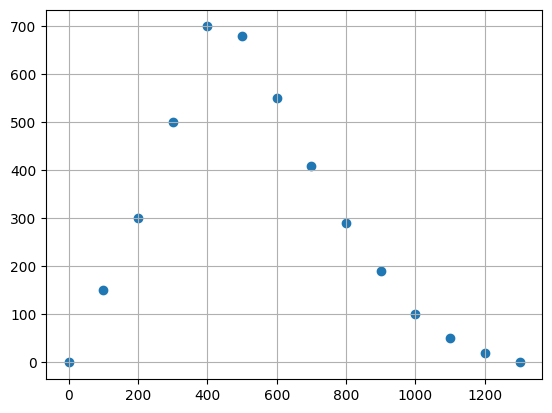

In [13]:
# Task C
# read in the trajectory points from data file
f = open('Rocket.txt','r')
temp = f.readlines()
f.close()
# clean the data
yn = []
for value in temp:
    yn += [int(value)]
yn = np.array(yn)
# set the time axis
tn = tn = np.linspace(0,1300,len(yn))
# plot the trajectory
pl.scatter(tn,yn)
pl.grid()


[ 1.5  1.5  2.   2.  -0.2 -1.3 -1.4 -1.2 -1.  -0.9 -0.5 -0.3 -0.2]


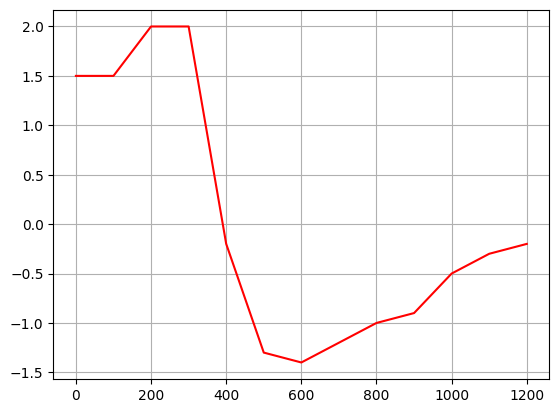

[ 0.     0.005  0.    -0.022 -0.011 -0.001  0.002  0.002  0.001  0.004
  0.002  0.001]


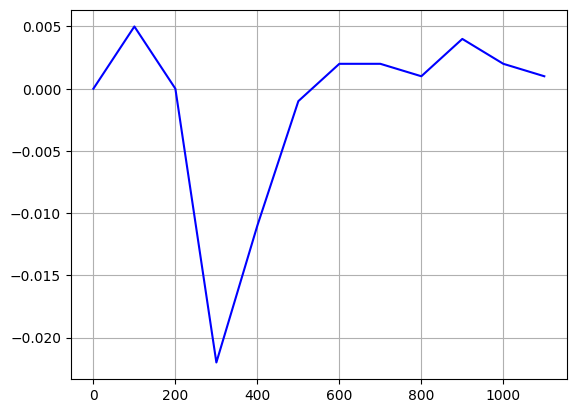

In [16]:
# Task C2
# determine velocity
k = 1
h = tn[1] - tn[0]
dyn = Derivative(yn,h,k)
print(dyn)
pl.plot(tn[:-k],dyn,c='Red')
pl.grid()
pl.show()

# determine acceleration
k = 2
dyn = Derivative(yn,h,k)
print(dyn)
pl.plot(tn[:-k],dyn,c='Blue')
pl.grid()
pl.show()

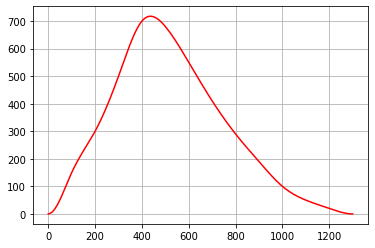

In [30]:
# Task C3
# set the domain of interpolation
t = np.linspace(0,1300,140)
bclower = 0
bcupper = 0
y = Spline(tn,yn,bclower,bcupper,t)
pl.plot(t,y,c='Red')
pl.grid()

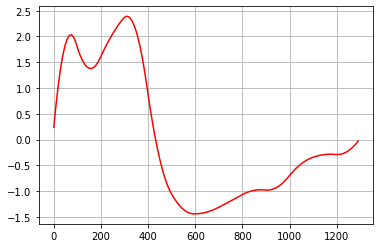

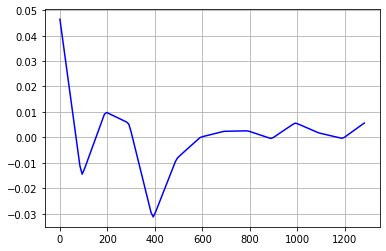

In [31]:
# determine velocity
k = 1
h = t[1] - t[0]
dy = Derivative(y,h,k)
pl.plot(t[:-k],dy,c='Red')
pl.grid()
pl.show()

# determine acceleration
k = 2
dy = Derivative(y,h,k)
pl.plot(t[:-k],dy,c='Blue')
pl.grid()
pl.show()

# Task D

In [47]:
# Gauss-Legendre quadrature nodes and weights
tg = np.array([ [0],
     [1/np.sqrt(3), -1/np.sqrt(3)], \
     [0, np.sqrt(3/5), -np.sqrt(3/5)], \
     [np.sqrt(3/7-2/7*np.sqrt(6/5)), -np.sqrt(3/7-2/7*np.sqrt(6/5)), \
            np.sqrt(3/7+2/7*np.sqrt(6/5)), -np.sqrt(3/7+2/7*np.sqrt(6/5))], \
     [0, 1/3*np.sqrt(5-2*np.sqrt(10/7)), -1/3*np.sqrt(5-2*np.sqrt(10/7)), \
     1/3*np.sqrt(5+2*np.sqrt(10/7)), -1/3*np.sqrt(5+2*np.sqrt(10/7))] ] )

wg = np.array([ [2], \
     [1, 1], \
     [8/9, 5/9, 5/9], \
     [(18+np.sqrt(30))/36, (18+np.sqrt(30))/36, (18-np.sqrt(30))/36, (18-np.sqrt(30))/36], \
     [128/225, (322+13*np.sqrt(70))/900, (322+13*np.sqrt(70))/900, \
      (322-13*np.sqrt(70))/900, (322-13*np.sqrt(70))/900] ])



In [48]:
# Gauss-Legendre quadrature (integration)
n = 5
a = 0
b = 1

S = 0
for i in range(0,n):
    x = 0.5*(a*(1-tg[n-1][i])+b*(tg[n-1][i]+1))
    S += f(x) * wg[n-1][i]
    
S = (b-a)/2*S

print(S)

0.7853981599711881
